# <FONT size="10pt"> <center>Projet 5</center></FONT>


### Notebook 3

#### <FONT size="10pt"> <center>Segmentez des clients d'un site e-commerce</center></FONT>



Vous êtes consultant pour **Olist**, une entreprise brésilienne qui propose une solution de vente sur les marketplaces en ligne.
Votre rôle est d’accompagner **Olist** dans leur projet de monter une équipe Data et leur premier cas d’usage Data Science autour de la segmentation client.

Base de Données : https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce/data


## Description des dataset

**Objectif**: 
*  Analyser en profondeur les données disponibles afin d'élaborer une stratégie de segmentation efficace..

**Analyse de la forme** : 
    
   * **orders**: informations sur les commandes et leur métadonnées
     * **variable target** : order_id mais reste à identifier
     * **Nombre des lignes et de colonnes** : 99441, 8
     * **Types de variables** :8 qualitatives  
     * **Analyse des valeurs manquantes** : moins de 5 % uniquemment sur les dates de livraison et de depart de livraison et data de confirmation de commande
         * les types colonnes temporelles sont à corriger si on les garde. 
  
  ------------------------
   * **orders_item**: informations sur le contenu des commandes
     * **variable target** : order_id , customer_id, seller_id, 
     * **Nombre des lignes et de colonnes** : 112650, 7
     * **Types de variables** :4 qualitatives, 3 quantitatives  
     * **Analyse des valeurs manquantes** : aucune 
   ----------------------------- 
   
   * **order_review**: informations sur les commantaires des commandes
     * **variable target** : order_id, review_score	
     * **Nombre des lignes et de colonnes** : 99224, 7
     * **Types de variables** :6 qualitatives, 1 quantitatives  
     * **Analyse des valeurs manquantes** : 90% et 60% sur les commentaire et leur titre. 
         * mettre " " pour corriger 
     
  ---------------------------------  
   * **products**: informations sur les produits, nom, taille, photos
     * **variable target** : product_id, product_category_name	
     * **Nombre des lignes et de colonnes** : 32951, 9
     * **Types de variables** :7 qualitatives, 2 quantitatives  
     * **Analyse des valeurs manquantes** : environ 8 % sur les dimensions et la catégorie
     * 73 catégories différentes > Tenter de réduire ce nombre. 
         * A traduire avec le dataset category name
     ---------------------------- 
   * **payments**: informations sur les paiements, montant, echelonnés ou pas, payé avec bon d'achat ou non  
     * **variable target** : product_id, product_category_name	
     * **Nombre des lignes et de colonnes** : 103886, 5
     * **Types de variables** :2 qualitatives, 3 quantitatives  
     * **Analyse des valeurs manquantes** : aucune 
     
     ----------------------------------
   * **customer**: informations sur les clients, et leur origine
     * **variable target** : customer_unique_id, 	
     * **Nombre des lignes et de colonnes** : 99441, 5
     * **Types de variables** :4 qualitatives, 1 quantitatives  
     * **Analyse des valeurs manquantes** : 0 valeurs manquantes
     
     ----------------------------------
     
     
   * **sellers**: informations sur les vendeurs, localisation
     * **variable target** :  seller_id	
     * **Nombre des lignes et de colonnes** : 3095, 4
     * **Types de variables** : 3 qualitatives, 1 quantitatives  
     * **Analyse des valeurs manquantes** : 0 valeurs manquantes 
     
     ----------------------------------
   * **geolocation**: informations sur la localisation des code postaux et villes utilisés dans les autres dataset
     * **variable target** : zip code
     * **Nombre des lignes et de colonnes** : 1000163, 5
     * **Types de variables** :2 qualitatives, 3 quantitatives  
     * **Analyse des valeurs manquantes** : 0 valeurs manquantes 
     * 8011 villes différentes or selon internet
             https://cidades.ibge.gov.br/brasil/panoramail y en a 5570 , des corrections a faire au niveau de accents et enventuellement traduction. 
    ----------------------------------
         
   * **category_name**: traduction en anglais des noms de produits
     * **variable target** :  product name	
     * **Nombre des lignes et de colonnes** : 71, 2
     * **Types de variables** :2 qualitatives 
     * **Analyse des valeurs manquantes** : 0 valeurs manquantes

## A- IMPORTATION DES LIBRAIRIES ET DES DONNEES

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from googletrans import Translator
import pickle
import math
from tqdm import tqdm
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from urllib.request import urlopen
import folium
import random
from PIL import Image
import branca.colormap as cm
import plotly.express as px
import scipy
import time
import os
from scipy.stats import f_oneway
from zoneinfo import ZoneInfo
from datetime import datetime, date
from tqdm import tqdm
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn.metrics import adjusted_rand_score, accuracy_score
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from ipyleaflet import Map, Marker, basemaps
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

pd.set_option('mode.chained_assignment', None) # Pour éviter la survenue de messages d'erreur lors de la création
                                                 # d'un nouveau dataframe à partir d'un existant

from warnings import filterwarnings
filterwarnings('ignore')  # code optionnel

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

#from IPython.display import display, HTML
#display(HTML("<style>.container { width:90% !important; }</style>")) # Largeur écran

## B- Définition des fonctions

### B.1- Table Produit

In [2]:
# Fonction pour traiter et organiser les informations des produits achetés :
def transformer_produits(fichier_csv):
    produits = pd.read_csv(fichier_csv)

    # Suppression de la colonne 'shipping_limit_date' :
    produits.drop(columns=['shipping_limit_date'], inplace=True)
    
    # Agrégation des données pour chaque commande afin de les consolider :
    produits = produits.groupby('order_id').agg({
        'product_id': 'count',          # Nombre total de produits par commande
        'seller_id': list,              # Liste des identifiants des vendeurs pour chaque commande
        'price': 'mean',                # Prix moyen des produits dans chaque commande
        'freight_value': 'mean'         # Valeur moyenne des frais de livraison par commande
    }).reset_index()

    # Conversion des listes de vendeurs en chaînes de caractères pour simplifier l'analyse :
    produits['seller_id'] = produits['seller_id'].apply(lambda x: ''.join(x))
    
    # Affichage des premières lignes du DataFrame modifié pour vérification :
    produits.head()
    
    return produits

### B.2- Table Commandes

In [3]:
# Fonction pour nettoyer et transformer les données des commandes :
def transformer_commandes(fichier_csv, date_ref):
    commandes = pd.read_csv(fichier_csv)
    
    # Filtrer pour conserver uniquement les commandes livrées :
    commandes = commandes[commandes['order_status'] == 'delivered']

    # Suppression de la colonne 'order_status' devenue inutile :
    commandes.drop(columns=['order_status'], inplace=True)
    
    # Conversion des colonnes de date en type datetime :
    colonnes_dates = [
        'order_delivered_customer_date',
        'order_purchase_timestamp',
        'order_approved_at',
        'order_delivered_carrier_date',
        'order_estimated_delivery_date'
    ]
    for date in colonnes_dates:
        commandes[date] = pd.to_datetime(commandes[date])
        
    commandes = commandes[commandes.order_purchase_timestamp <= date_ref]
    
    # Suppression des lignes sans date de livraison au client :
    commandes = commandes[commandes['order_delivered_customer_date'].notna()]
    
    # Extraction du mois de la commande :
    commandes['Mois_achat'] = commandes['order_purchase_timestamp'].dt.month

    # Extraction de l'année de la commande :
    commandes['Annee_achat'] = commandes['order_purchase_timestamp'].dt.year

    # Extraction de la semaine de la commande (calendrier ISO) :
    commandes['Semaine_achat'] = commandes['order_purchase_timestamp'].apply(lambda x: x.isocalendar()[1])
    
    # Création d'une colonne pour le délai de livraison en jours :
    commandes['Delais_livraison_jours'] = commandes['order_delivered_customer_date'] - commandes['order_purchase_timestamp']
    commandes['Delais_livraison_jours'] = commandes['Delais_livraison_jours'].apply(lambda x: int(str(pd.Timedelta(x).round(freq='d')).split(' ')[0]))
    
    # Création d'une colonne pour le retard de livraison en jours :
    commandes['Retard_livraison_jours'] = commandes['order_delivered_customer_date'] - commandes['order_estimated_delivery_date']
    commandes['Retard_livraison_jours'] = commandes['Retard_livraison_jours'].apply(lambda x: int(str(pd.Timedelta(x).round(freq='d')).split(' ')[0]))
    commandes['Retard_livraison_jours'] = commandes['Retard_livraison_jours'].apply(lambda x: 0 if x < 0 else x)
    
    ## Définir la date de référence comme étant "maintenant" en 2019 vu que la derniere date est de 2018
    # Création d'une colonne pour le délai depuis le dernier achat (référence 2019) :
    #now = np.datetime64(datetime.now(tz=ZoneInfo("America/Sao_Paulo")) - relativedelta(years=6))
    now = date_ref
    commandes['Delais_dernier_achat_jours'] = commandes['order_purchase_timestamp'].apply(lambda x: int(str((now - x).round('d')).split(' ')[0]))
    
    # Suppression des colonnes de temps désormais inutiles :
    commandes.drop(columns=[
        #'order_purchase_timestamp',
        'order_approved_at',
        'order_delivered_carrier_date',
        'order_delivered_customer_date',
        'order_estimated_delivery_date'
    ], inplace=True)
    
    return commandes

### B.3- Table reviews (commentaires)

In [4]:
# Fonction pour nettoyer et transformer les données des avis :
def transformer_reviews(fichier_csv):
    reviews = pd.read_csv(fichier_csv)
    
    # Transformation de la colonne des messages de commentaires :
    reviews['review_comment_message'] = reviews['review_comment_message'].apply(lambda x: 1 if isinstance(x, str) else 0)

    # Suppression des colonnes non nécessaires :
    reviews.drop(columns=['review_id', 'review_comment_title', 
                          'review_creation_date', 'review_answer_timestamp', 
                          'review_comment_message'], inplace=True)
    
    # Agrégation des données par commande en prenant le minimum pour les scores (tendance à diminuer avec les messages des clients) :
    reviews = reviews.groupby('order_id').mean().reset_index()

    return reviews

### B.4- Table payments (paiements)

In [5]:
# Fonction pour nettoyer et transformer les données des paiements :
def transformer_payments(fichier_csv):
    payments = pd.read_csv(fichier_csv)

    # Regroupement des données par commande pour obtenir le nombre maximum d'échéances de paiement par commande :
    max_installments = payments.groupby('order_id')['payment_installments'].max().to_frame()

    # Transformation de la table pour avoir une ligne par commande et des colonnes pour chaque type de paiement :
    payments_pivot = pd.pivot_table(payments, index='order_id', columns='payment_type', values='payment_value')

    # Fusion des deux tables pour conserver les échéances maximales et les types de paiements :
    payments = pd.merge(payments_pivot, max_installments, left_index=True, right_index=True)

    # Réinitialisation de l'index pour transformer les index en colonnes :
    payments.reset_index(inplace=True)

    # Remplissage des valeurs manquantes avec zéro pour éviter les erreurs dans les calculs ultérieurs :
    payments.fillna(0, inplace=True)
    
    # Suppression de la colonne 'not_defined' si elle existe, car elle n'est pas utile :
    if 'not_defined' in payments.columns:
        payments.drop(columns=['not_defined'], inplace=True)
    
    # Combinaison des colonnes 'credit_card' et 'debit_card' en une seule colonne 'CB' pour simplifier l'analyse :
    if 'credit_card' in payments.columns and 'debit_card' in payments.columns:
        payments['CB'] = payments['credit_card'] + payments['debit_card']
        payments.drop(columns=['credit_card', 'debit_card'], inplace=True)

    # Renommage des colonnes pour une meilleure compréhension :
    payments.columns = ['order_id', 'Billets', 'Bons', 'Nombre_de_Paiement', 'CB']

    # Suppression des colonnes 'Billets', 'Bons' et 'CB' car elles ne sont pas nécessaires pour le moment :
    columns_to_drop = ['Billets', 'Bons', 'CB']
    payments.drop(columns=[col for col in columns_to_drop if col in payments.columns], inplace=True)
    
    return payments

### B.5- Table vendeurs

In [6]:
# Fonction pour nettoyer et transformer les données des vendeurs :
def transformer_vendeurs(fichier_csv):
    vendeurs = pd.read_csv(fichier_csv)
    
    # Suppression de la colonne 'seller_zip_code_prefix' car elle n'est pas nécessaire pour l'analyse :
    vendeurs.drop(columns=['seller_zip_code_prefix'], inplace=True)
    
    # Suppression de la colonne 'seller_state' car elle n'est pas nécessaire pour l'analyse :
    vendeurs.drop(columns=['seller_state'], inplace=True)
    
    return vendeurs

### B.6- Table géolocalisation

In [7]:
# Fonction pour nettoyer et transformer les données de géolocalisation :
def transformer_geolocalisation(fichier_csv):
    geolocalisation = pd.read_csv(fichier_csv)
    
    # Regroupement par ville pour obtenir les coordonnées moyennes de chaque ville :
    geolocalisation = geolocalisation.groupby('geolocation_city').agg({
        'geolocation_lat': 'mean',  # Calcul de la latitude moyenne
        'geolocation_lng': 'mean',  # Calcul de la longitude moyenne
        'geolocation_city': 'unique',  # Conservation du nom unique de la ville
        'geolocation_state': 'unique'  # Conservation de l'état unique
    })

    # Création d'une nouvelle colonne 'Coordonnees' combinant latitude et longitude :
    def combiner_coordonnees(value):
        lat, long = value['geolocation_lat'], value['geolocation_lng']
        return [lat, long]

    geolocalisation['Coordonnees'] = geolocalisation[['geolocation_lat', 'geolocation_lng']].apply(combiner_coordonnees, axis=1)
    
    # Suppression des colonnes devenues inutiles après la création de 'Coordonnees' :
    geolocalisation.drop(columns=['geolocation_lat', 'geolocation_lng', 'geolocation_state'], inplace=True)

    # Simplification de la colonne 'geolocation_city' pour ne garder que le nom de la ville :
    geolocalisation['geolocation_city'] = geolocalisation['geolocation_city'].apply(lambda x: x[0])
    
    # Réinitialisation de l'index pour une meilleure présentation :
    geolocalisation.reset_index(drop=True, inplace=True)
    
    return geolocalisation

### B.7- Table clients

In [8]:
# Fonction pour nettoyer et transformer les données des clients :
def transformer_clients(fichier_csv):
    clients = pd.read_csv(fichier_csv)

    # Suppression de la colonne 'customer_zip_code_prefix' car elle n'est pas nécessaire pour l'analyse :
    clients.drop(columns=['customer_zip_code_prefix'], inplace=True)
    
    # Suppression de la colonne 'customer_state' car elle n'est pas nécessaire pour l'analyse :
    clients.drop(columns=['customer_state'], inplace=True)
    
    return clients

# C- Jointure des fichiers et transformation des fichiers joints

In [9]:
def transforme_fusion(date_ref):

    # Nettoyage des fichiers :
    produits = transformer_produits('olist_order_items_dataset.csv')
    commandes = transformer_commandes('olist_orders_dataset.csv', date_ref)
    reviews = transformer_reviews('olist_order_reviews_dataset.csv')
    clients = transformer_clients('olist_customers_dataset.csv')

    # Merge des fichiers pour créer le DataFrame final :
    Data_Final = commandes.copy()  # Copier les données de commandes pour commencer la fusion
    Data_Final = pd.merge(Data_Final, clients, how='inner')  # Fusionner avec les données de clients
    Data_Final = pd.merge(Data_Final, reviews, how='inner')  # Fusionner avec les données d'avis
    Data_Final = pd.merge(Data_Final, produits, how='inner')  # Fusionner avec les données de produits

    # Suppression des colonnes d'ID non nécessaires (sauf l'ID unique) :
    Data_Final.drop(columns=[ 'seller_id', 'product_id', 'customer_id', 'order_id', 'customer_city'], inplace=True)

    # Suppression des colonnes de villes des clients et des vendeurs car elles ne sont pas utiles pour l'analyse :
    #Data_Final.drop(columns=['customer_city', 'seller_city'], inplace=True)

    # Création d'une colonne pour le nombre maximum de commandes par client unique :
    Nombre_de_commande = Data_Final['customer_unique_id'].value_counts().to_frame().reset_index().rename(columns={'customer_unique_id': 'Nombre_de_commande', 'index': 'customer_unique_id'})
    Data_Final = pd.merge(Data_Final, Nombre_de_commande, how='inner')

    # Ajout d'une colonne pour le coût total avec frais de livraison :
    Data_Final['CoutTotalAvecFraisDeLivraison'] = Data_Final['price'] + Data_Final['freight_value']

    # Conversion de certaines colonnes de type float en type int pour éviter les erreurs de type :
    colonnes_a_convertir = ['Delais_livraison_jours', 'Retard_livraison_jours', 'review_score']
    for colonne in colonnes_a_convertir:
        Data_Final[colonne] = Data_Final[colonne].astype(int)

    # Transformation logarithmique pour certaines colonnes pour la normalisation des données :
    colonnes_logarithmiques = ['CoutTotalAvecFraisDeLivraison']
    for colonne in colonnes_logarithmiques:
        Data_Final[colonne + '(log)'] = np.log1p(Data_Final[colonne])  # Utilisation de np.log1p pour éviter log(0)

    df_simulation = Data_Final[["Delais_dernier_achat_jours",
                                           "Nombre_de_commande", "CoutTotalAvecFraisDeLivraison(log)",
                                           "review_score", "order_purchase_timestamp"]]
    return df_simulation

In [10]:
data1 = transforme_fusion(np.datetime64("2017-12-31 00:00:00"))
data2 = transforme_fusion(np.datetime64("2018-01-31 00:00:00"))

In [11]:
print("Date du dernier achat", data1.order_purchase_timestamp.max())
print("Date du premier achat", data1.order_purchase_timestamp.min())

print("Date du dernier achat", data2.order_purchase_timestamp.max())
print("Date du premier achat", data2.order_purchase_timestamp.min())

Date du dernier achat 2017-12-30 23:53:28
Date du premier achat 2016-09-15 12:16:38
Date du dernier achat 2018-01-30 23:59:43
Date du premier achat 2016-09-15 12:16:38


## D- Initialisation avec un an de données. 

**Période T0** = 12 mois

#### T1=T0 + 60 jours

In [12]:
from sklearn.metrics import adjusted_rand_score
from pandas.tseries.offsets import DateOffset

np_datetime = np.datetime64("2017-12-31 00:00:00")
dt_datetime = np_datetime.astype('M8[ms]').astype('O')
result_datetime = dt_datetime - relativedelta(months=2)
result_np_datetime = np.datetime64(result_datetime)

# Filtrer les données pour la première année
df_initial_year = transforme_fusion(np.datetime64("2017-12-31 00:00:00"))
# Filtrer les données pour la première année plus un nombre variable de jours
df_adjusted_period = transforme_fusion(result_np_datetime)
    
# Supprimer la colonne des timestamps des commandes, car plus utile
df_initial_year = df_initial_year.drop("order_purchase_timestamp", axis=1)
df_adjusted_period = df_adjusted_period.drop("order_purchase_timestamp", axis=1)

# Standardiser les données du premier jeu de données
scaler_initial_year = StandardScaler()
df_initial_year_scaled = pd.DataFrame(data=scaler_initial_year.fit_transform(df_initial_year), columns=df_initial_year.columns)

# Standardiser les données du second jeu de données
scaler_adjusted_period = StandardScaler()
df_adjusted_period_scaled = pd.DataFrame(data=scaler_adjusted_period.fit_transform(df_adjusted_period), columns=df_adjusted_period.columns)

# Appliquer l'algorithme KMeans pour le premier jeu de données
kmeans_initial_year = KMeans(n_clusters=5, random_state=1)
kmeans_initial_year.fit(df_initial_year_scaled)

# Appliquer l'algorithme KMeans pour le second jeu de données
kmeans_adjusted_period = KMeans(n_clusters=5, random_state=1)
kmeans_adjusted_period.fit(df_adjusted_period_scaled)

# Prédire les clusters pour le second jeu de données
clusters_adjusted_period = kmeans_adjusted_period.predict(df_adjusted_period_scaled)
# Prédire les clusters pour le second jeu de données en utilisant le modèle du premier jeu de données
clusters_initial_year_transformed = kmeans_initial_year.predict(scaler_initial_year.transform(df_adjusted_period))

# Calculer l'Adjusted Rand Index (ARI) entre les deux clusterings
ari_score_60_jours = adjusted_rand_score(clusters_adjusted_period, clusters_initial_year_transformed)
ari_score_60_jours

0.7970337221876305

#### T1=T0 + 30 jours

In [13]:
np_datetime = np.datetime64("2017-12-31 00:00:00")
dt_datetime = np_datetime.astype('M8[ms]').astype('O')
result_datetime = dt_datetime - relativedelta(months=1)
result_np_datetime = np.datetime64(result_datetime)

# Filtrer les données pour la première année
df_initial_year = transforme_fusion(np.datetime64("2017-12-31 00:00:00"))
# Filtrer les données pour la première année plus un nombre variable de jours
df_adjusted_period = transforme_fusion(result_np_datetime)

# Supprimer la colonne des timestamps des commandes, car plus utile
df_initial_year = df_initial_year.drop("order_purchase_timestamp", axis=1)
df_adjusted_period = df_adjusted_period.drop("order_purchase_timestamp", axis=1)

# Standardiser les données du premier jeu de données
scaler_initial_year = StandardScaler()
df_initial_year_scaled = pd.DataFrame(data=scaler_initial_year.fit_transform(df_initial_year), columns=df_initial_year.columns)

# Standardiser les données du second jeu de données
scaler_adjusted_period = StandardScaler()
df_adjusted_period_scaled = pd.DataFrame(data=scaler_adjusted_period.fit_transform(df_adjusted_period), columns=df_adjusted_period.columns)

# Appliquer l'algorithme KMeans pour le premier jeu de données
kmeans_initial_year = KMeans(n_clusters=5, random_state=1)
kmeans_initial_year.fit(df_initial_year_scaled)

# Appliquer l'algorithme KMeans pour le second jeu de données
kmeans_adjusted_period = KMeans(n_clusters=5, random_state=1)
kmeans_adjusted_period.fit(df_adjusted_period_scaled)

# Prédire les clusters pour le second jeu de données
clusters_adjusted_period = kmeans_adjusted_period.predict(df_adjusted_period_scaled)
# Prédire les clusters pour le second jeu de données en utilisant le modèle du premier jeu de données
clusters_initial_year_transformed = kmeans_initial_year.predict(scaler_initial_year.transform(df_adjusted_period))

# Calculer l'Adjusted Rand Index (ARI) entre les deux clusterings
ari_score_30_jours = adjusted_rand_score(clusters_adjusted_period, clusters_initial_year_transformed)
ari_score_30_jours

0.8890317270034392

#### T1=T0 + 7 jours

In [14]:
np_datetime = np.datetime64("2017-12-31 00:00:00")
dt_datetime = np_datetime.astype('M8[ms]').astype('O')
result_datetime = dt_datetime - relativedelta(days=7)
result_np_datetime = np.datetime64(result_datetime)

# Filtrer les données pour la première année
df_initial_year = transforme_fusion(np.datetime64("2017-12-31 00:00:00"))
# Filtrer les données pour la première année plus un nombre variable de jours
df_adjusted_period = transforme_fusion(result_np_datetime)

# Supprimer la colonne des timestamps des commandes, car plus utile
df_initial_year = df_initial_year.drop("order_purchase_timestamp", axis=1)
df_adjusted_period = df_adjusted_period.drop("order_purchase_timestamp", axis=1)

# Standardiser les données du premier jeu de données
scaler_initial_year = StandardScaler()
df_initial_year_scaled = pd.DataFrame(data=scaler_initial_year.fit_transform(df_initial_year), columns=df_initial_year.columns)

# Standardiser les données du second jeu de données
scaler_adjusted_period = StandardScaler()
df_adjusted_period_scaled = pd.DataFrame(data=scaler_adjusted_period.fit_transform(df_adjusted_period), columns=df_adjusted_period.columns)

# Appliquer l'algorithme KMeans pour le premier jeu de données
kmeans_initial_year = KMeans(n_clusters=5, random_state=1)
kmeans_initial_year.fit(df_initial_year_scaled)

# Appliquer l'algorithme KMeans pour le second jeu de données
kmeans_adjusted_period = KMeans(n_clusters=5, random_state=1)
kmeans_adjusted_period.fit(df_adjusted_period_scaled)

# Prédire les clusters pour le second jeu de données
clusters_adjusted_period = kmeans_adjusted_period.predict(df_adjusted_period_scaled)
# Prédire les clusters pour le second jeu de données en utilisant le modèle du premier jeu de données
clusters_initial_year_transformed = kmeans_initial_year.predict(scaler_initial_year.transform(df_adjusted_period))

# Calculer l'Adjusted Rand Index (ARI) entre les deux clusterings
ari_score_7_jours = adjusted_rand_score(clusters_adjusted_period, clusters_initial_year_transformed)
ari_score_7_jours

0.9631213785865685

#### T1=T0 + 2 jours

In [15]:
np_datetime = np.datetime64("2017-12-31 00:00:00")
dt_datetime = np_datetime.astype('M8[ms]').astype('O')
result_datetime = dt_datetime - relativedelta(days=2)
result_np_datetime = np.datetime64(result_datetime)

# Filtrer les données pour la première année
df_initial_year = transforme_fusion(np.datetime64("2017-12-31 00:00:00"))
# Filtrer les données pour la première année plus un nombre variable de jours
df_adjusted_period = transforme_fusion(result_np_datetime)
    
# Supprimer la colonne des timestamps des commandes, car plus utile
df_initial_year = df_initial_year.drop("order_purchase_timestamp", axis=1)
df_adjusted_period = df_adjusted_period.drop("order_purchase_timestamp", axis=1)

# Standardiser les données du premier jeu de données
scaler_initial_year = StandardScaler()
df_initial_year_scaled = pd.DataFrame(data=scaler_initial_year.fit_transform(df_initial_year), columns=df_initial_year.columns)

# Standardiser les données du second jeu de données
scaler_adjusted_period = StandardScaler()
df_adjusted_period_scaled = pd.DataFrame(data=scaler_adjusted_period.fit_transform(df_adjusted_period), columns=df_adjusted_period.columns)

# Appliquer l'algorithme KMeans pour le premier jeu de données
kmeans_initial_year = KMeans(n_clusters=5, random_state=1)
kmeans_initial_year.fit(df_initial_year_scaled)

# Appliquer l'algorithme KMeans pour le second jeu de données
kmeans_adjusted_period = KMeans(n_clusters=5, random_state=1)
kmeans_adjusted_period.fit(df_adjusted_period_scaled)

# Prédire les clusters pour le second jeu de données
clusters_adjusted_period = kmeans_adjusted_period.predict(df_adjusted_period_scaled)
# Prédire les clusters pour le second jeu de données en utilisant le modèle du premier jeu de données
clusters_initial_year_transformed = kmeans_initial_year.predict(scaler_initial_year.transform(df_adjusted_period))

# Calculer l'Adjusted Rand Index (ARI) entre les deux clusterings
ari_score_2_jours = adjusted_rand_score(clusters_adjusted_period, clusters_initial_year_transformed)
ari_score_2_jours

0.98893661521683

#### T1=T0 + 15 jours

In [16]:
np_datetime = np.datetime64("2017-12-31 00:00:00")
dt_datetime = np_datetime.astype('M8[ms]').astype('O')
result_datetime = dt_datetime - relativedelta(days=15)
result_np_datetime = np.datetime64(result_datetime)

# Filtrer les données pour la première année
df_initial_year = transforme_fusion(np.datetime64("2017-12-31 00:00:00"))
# Filtrer les données pour la première année plus un nombre variable de jours
df_adjusted_period = transforme_fusion(result_np_datetime)
    
# Supprimer la colonne des timestamps des commandes, car plus utile
df_initial_year = df_initial_year.drop("order_purchase_timestamp", axis=1)
df_adjusted_period = df_adjusted_period.drop("order_purchase_timestamp", axis=1)

# Standardiser les données du premier jeu de données
scaler_initial_year = StandardScaler()
df_initial_year_scaled = pd.DataFrame(data=scaler_initial_year.fit_transform(df_initial_year), columns=df_initial_year.columns)

# Standardiser les données du second jeu de données
scaler_adjusted_period = StandardScaler()
df_adjusted_period_scaled = pd.DataFrame(data=scaler_adjusted_period.fit_transform(df_adjusted_period), columns=df_adjusted_period.columns)

# Appliquer l'algorithme KMeans pour le premier jeu de données
kmeans_initial_year = KMeans(n_clusters=5, random_state=1)
kmeans_initial_year.fit(df_initial_year_scaled)

# Appliquer l'algorithme KMeans pour le second jeu de données
kmeans_adjusted_period = KMeans(n_clusters=5, random_state=1)
kmeans_adjusted_period.fit(df_adjusted_period_scaled)

# Prédire les clusters pour le second jeu de données
clusters_adjusted_period = kmeans_adjusted_period.predict(df_adjusted_period_scaled)
# Prédire les clusters pour le second jeu de données en utilisant le modèle du premier jeu de données
clusters_initial_year_transformed = kmeans_initial_year.predict(scaler_initial_year.transform(df_adjusted_period))

# Calculer l'Adjusted Rand Index (ARI) entre les deux clusterings
ari_score = adjusted_rand_score(clusters_adjusted_period, clusters_initial_year_transformed)
ari_score

0.9096897489988371

In [18]:
from dateutil.relativedelta import relativedelta

# Initialiser une liste pour stocker les résultats de l'Adjusted Rand Index (ARI)
ari_results = []

# Calculer l'ARI pour différentes périodes (de 0 à 300 jours avec un pas de 15 jours)
for days_offset in range(0, 300, 15):
    np_datetime = np.datetime64("2017-12-31 00:00:00")
    dt_datetime = np_datetime.astype('M8[ms]').astype('O')
    result_datetime = dt_datetime - relativedelta(days=days_offset)
    result_np_datetime = np.datetime64(result_datetime)

    # Filtrer les données pour la première année
    df_initial_year = transforme_fusion(np_datetime)
    # Filtrer les données pour la première année plus un nombre variable de jours
    df_adjusted_period = transforme_fusion(result_np_datetime)

    # Supprimer la colonne des timestamps des commandes, car plus utile
    df_initial_year = df_initial_year.drop("order_purchase_timestamp", axis=1)
    df_adjusted_period = df_adjusted_period.drop("order_purchase_timestamp", axis=1)

    # Standardiser les données du premier jeu de données
    scaler_initial_year = StandardScaler()
    df_initial_year_scaled = pd.DataFrame(data=scaler_initial_year.fit_transform(df_initial_year), columns=df_initial_year.columns)

    # Standardiser les données du second jeu de données
    scaler_adjusted_period = StandardScaler()
    df_adjusted_period_scaled = pd.DataFrame(data=scaler_adjusted_period.fit_transform(df_adjusted_period), columns=df_adjusted_period.columns)

    # Appliquer l'algorithme KMeans pour le premier jeu de données
    kmeans_initial_year = KMeans(n_clusters=5, random_state=1)
    kmeans_initial_year.fit(df_initial_year_scaled)

    # Appliquer l'algorithme KMeans pour le second jeu de données
    kmeans_adjusted_period = KMeans(n_clusters=5, random_state=1)
    kmeans_adjusted_period.fit(df_adjusted_period_scaled)

    # Prédire les clusters pour le second jeu de données
    clusters_adjusted_period = kmeans_adjusted_period.predict(df_adjusted_period_scaled)
    # Prédire les clusters pour le second jeu de données en utilisant le modèle du premier jeu de données
    clusters_initial_year_transformed = kmeans_initial_year.predict(scaler_initial_year.transform(df_adjusted_period))

    # Calculer l'Adjusted Rand Index (ARI) entre les deux clusterings
    ari_score_jours = adjusted_rand_score(clusters_adjusted_period, clusters_initial_year_transformed)

    # Ajouter le résultat à la liste
    ari_results.append((days_offset, ari_score_jours))

In [19]:
# Convertir les résultats en DataFrame pour une meilleure visualisation
df_ari_results = pd.DataFrame(ari_results, columns=['periode', 'ARI'])

# Afficher le DataFrame des résultats
print(df_ari_results)

    periode       ARI
0         0  1.000000
1        15  0.909690
2        30  0.891480
3        45  0.854361
4        60  0.446424
5        75  0.750739
6        90  0.688220
7       105  0.652350
8       120  0.340948
9       135  0.576997
10      150  0.536375
11      165  0.521428
12      180  0.518703
13      195  0.520832
14      210  0.507006
15      225  0.510563
16      240  0.664524
17      255  0.581854
18      270  0.651431
19      285  0.476482


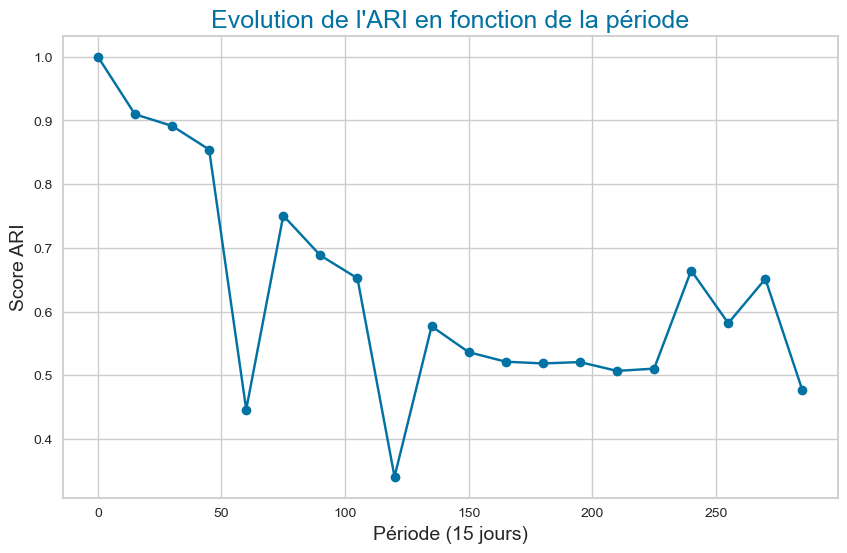

In [20]:
# Créer une figure pour le graphique avec une taille spécifique
plt.figure(figsize=(10, 6))

# Tracer les résultats de l'ARI en fonction de la période
plt.plot(df_ari_results['periode'], df_ari_results['ARI'], marker='o', linestyle='-')

# Ajouter un titre au graphique
plt.title("Evolution de l'ARI en fonction de la période", fontsize=18, color="b")
plt.xlabel('Période (15 jours)', fontsize=14)
plt.ylabel('Score ARI', fontsize=14)

# Ajouter une grille pour améliorer la lisibilité
plt.grid(True)

# Afficher le graphique
plt.show()

On remarque une stabilité du score ARI jusqu'à environ 45 jours, suivie d'une chute marquée. Après environ 50 jours, il y a une légère remontée, mais la tendance générale est à la baisse continue avec des fluctuations autour de 150 jours. Vers 225 jours, on observe un rebond, suivi de nouvelles fluctuations, mais la tendance générale continue de baisser jusqu'à 300 jours. Cette diminution constante pourrait s'expliquer par les cycles de commande observés dans l'analyse exploratoire.

**Surveillance Continue** : Continuez à surveiller l'ARI après chaque ré-entraînement pour ajuster les intervalles si nécessaire.


**Adaptation Flexible** : Ajustez les périodes de ré-entraînement en fonction des nouvelles données et des tendances observées.